In [1]:
import gymnasium as gym
import numpy as np
import ipywidgets as widgets
import sys

sys.path.append('../')
import support_modules as sm

# Frozen Lake

## Description
<div style="text-align: justify">    
The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment.

Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated.

The player makes moves until they reach the goal or fall in a hole.

The lake is slippery (unless disabled) so the player may move perpendicular to the intended direction sometimes (see is_slippery).

Randomly generated worlds will always have a path to the goal.

Elf and stool from https://franuka.itch.io/rpg-snow-tileset. All other assets by Mel Tillery http://www.cyaneus.com/.
</div>

https://gymnasium.farama.org/environments/toy_text/frozen_lake/

# Random Policy

## Single episode

In [142]:
env = gym.make('FrozenLake-v1', render_mode='human')
state, _ = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

## Exploratory 1000 episodes

In [12]:
env = gym.make('FrozenLake-v1', render_mode=None)

rewards = list()
success = list()

for episode in range(1000):
    state, _ = env.reset()
    ep_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)
    
    rewards.append(ep_reward)
    success.append(state==15)

env.close()
print(f'Success rate: {sum(success)/len(success)}')
print(f'Average reward: {sum(rewards)/len(rewards)}')

Success rate: 0.021
Average reward: 0.021


# User Custom Policy (interacting with environment)

In [112]:
env = gym.make('FrozenLake-v1', render_mode='human')
state, _ = env.reset()
done = False

while not done:
    action = int(input('Select next action'))
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

# Empiric Conservative Policy

In [24]:
def conservative_policy(state):
    if state in [0,4,6,10]: return 0
    elif state in [9,14]: return 1
    elif state in [13]: return 2
    elif state in [1,2,3,8]:  return 3

## Visualizing Conservative Policy

In [8]:
env = gym.make('FrozenLake-v1', render_mode='human')
state, _ = env.reset()
done = False

while not done:
    action = conservative_policy(state)
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

## Testing Conservative Policy on 100 Episodes

In [25]:
env = gym.make('FrozenLake-v1', render_mode=None)

rewards = list()
success = list()

for episode in range(100):
    state, _ = env.reset()
    ep_reward = 0
    done = False

    while not done:
        action = conservative_policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)
    
    rewards.append(ep_reward)
    success.append(state==15)

env.close()
print(f'Success rate: {sum(success)/len(success)}')
print(f'Average reward: {sum(rewards)/len(rewards)}')

Success rate: 0.75
Average reward: 0.75


# Q-Learning

In [3]:
# Flexible Parameters (ipywidgets)
EPISODES_W = widgets.IntSlider(value=200000, min=50, max=150000, step=50, description='Number Episodes', 
                               style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

LEARNING_RATE_W = widgets.FloatSlider(value=0.01, min=0, max=1, step=0.01, description='Learning rate',
                                      style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})
DISCOUNT_W = widgets.FloatSlider(value=0.99, min=0, max=1, step=0.01, description='Discount factor',
                                 style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

epsilon_W = widgets.FloatSlider(value=0.95, min=0, max=1, step=0.05, description='Exploration rate',
                                style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

display(EPISODES_W,LEARNING_RATE_W,DISCOUNT_W,epsilon_W)

START_EPSILON_DECAYING = 1                      # First episode at which decay epsilon

IntSlider(value=150000, description='Number Episodes', layout=Layout(width='40%'), max=150000, min=50, step=50…

FloatSlider(value=0.01, description='Learning rate', layout=Layout(width='40%'), max=1.0, step=0.01, style=Sli…

FloatSlider(value=0.99, description='Discount factor', layout=Layout(width='40%'), max=1.0, step=0.01, style=S…

FloatSlider(value=0.95, description='Exploration rate', layout=Layout(width='40%'), max=1.0, step=0.05, style=…

In [4]:
env = gym.make('FrozenLake-v1', render_mode=None, map_name = '4x4',max_episode_steps=300)

# Retrieving 
EPISODES = EPISODES_W.value; LEARNING_RATE = LEARNING_RATE_W.value
DISCOUNT = DISCOUNT_W.value; epsilon = epsilon_W.value
epsilon_decaying_value = epsilon / ((EPISODES//1.5) - START_EPSILON_DECAYING)     # Amount of decayment of epsilon    

DISCOUNT = 0.995;LEARNING_RATE=0.005

# Generate the q_table 
q_table = sm.Q_Learning_Agent.generate_q_table('zeros',env.action_space.n,[env.observation_space.n])

# Rewards
ep_rewards = list()
success = list()
epsilons = list()


### Training
for episode in range(EPISODES):
    
    episode_reward = 0
    state, info = env.reset()
    done = False
    
    while not done: 

        if np.random.random() > epsilon:                    # Randomize actions with epsilon
            action = np.argmax(q_table[state])              # Action taken from the argmax of the current state
        else:
            action = env.action_space.sample()              # Action taken at random
        
        new_state, reward, terminated, truncated, info = env.step(action)       # Retrieve information
        done = sm.evaluate_done(terminated,truncated)

        episode_reward += reward
        
        if not done: 
            q_table = sm.Q_Learning_Agent.update_q_table(q_table,(state,),(new_state,),action,reward,LEARNING_RATE,DISCOUNT)
        
        elif new_state==15:
            q_table[(state,) + (action, )] = 1        # Update value when goal is reached
        
        #### REWARD SHAPING
        elif new_state in [5,7,11,12]:
            q_table[(state,) + (action, )] = -1        # Update value when falling into a hole

        state = new_state                 # Update state
    
    epsilon = sm.Q_Learning_Agent.linear_epsilon_decay(epsilon,episode,epsilon_decaying_value,START_EPSILON_DECAYING,EPISODES//1.5)
    
    ep_rewards.append(episode_reward)
    success.append(state==15)
    epsilons.append(epsilon)
     
env.close()

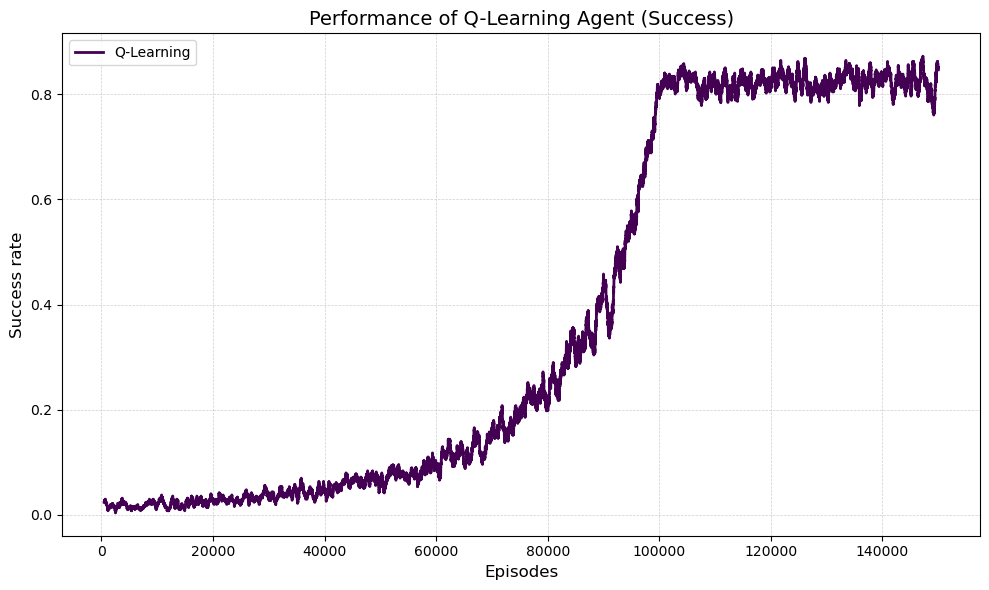

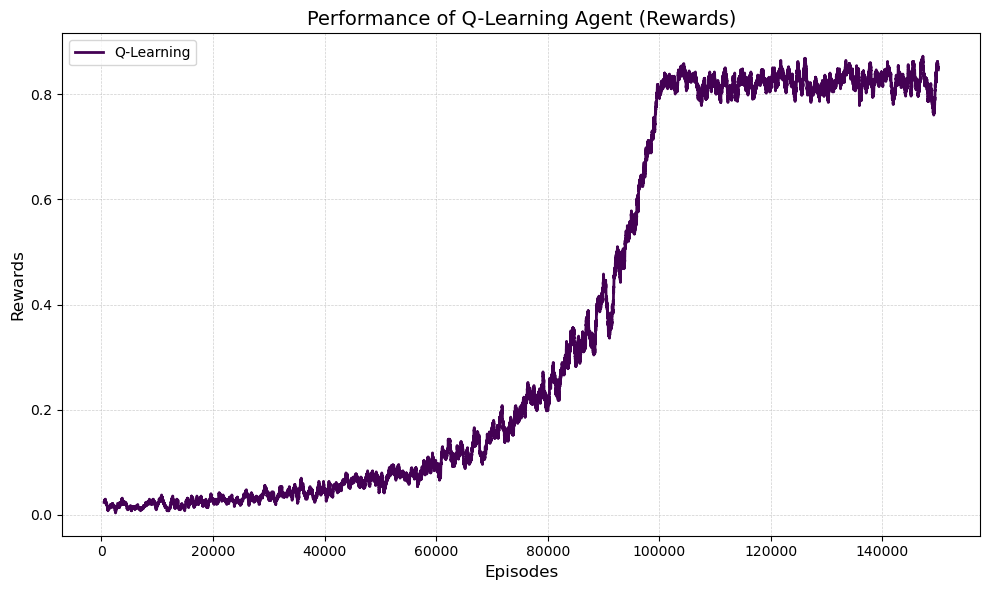

In [5]:
# Visualizing training results
sm.visualizations.plot_moving_average([success],['Q-Learning'],500,
                                      title='Performance of Q-Learning Agent (Success)',ylabel='Success rate')
sm.visualizations.plot_moving_average([ep_rewards],['Q-Learning'],500,
                                      title='Performance of Q-Learning Agent (Rewards)',ylabel='Rewards')

## Testing

### Visualizing Trained Agent

In [36]:
env = gym.make('FrozenLake-v1', render_mode='human')
state, _ = env.reset()
done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

### Testing Agent on 100 New Episodes

In [6]:
env = gym.make('FrozenLake-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action = np.argmax(q_table[state])
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_success.append(state==15)
    testing_rewards.append(ep_reward)
env.close()

print(f'Success rate of Q-Learning Agent on 100 episodes: {round(sum(testing_success)/len(testing_success),2)}')
print(f'Average rewards of Q-Learning Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Success rate of Q-Learning Agent on 100 episodes: 0.82
Average rewards of Q-Learning Agent on 100 episodes: 0.82


### Visualizing Q-Table

In [7]:
def visualize_q_table(q_table):
    nrows, ncols = 4, 4
    q_table_reshaped = q_table.reshape(nrows, ncols, -1)

    arrow_symbols = ['←', '↓', '→', '↑']

    for i in range(nrows):
        for j in range(ncols):
            if i*nrows+  j not in [5,7,11,12]:
                max_action_index = np.argmax(q_table_reshaped[i, j])
                arrow = arrow_symbols[max_action_index]
                print(f"{arrow} ", end="")
            else: print(f". ", end="")
        print()

print('Visualizing Q-Learning Agent Policy:')
visualize_q_table(q_table)

Visualizing Q-Learning Agent Policy:
← ↑ ↑ ↑ 
← . ← . 
↑ ↓ ← . 
. → ↓ ← 
